In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
import pybert as pb

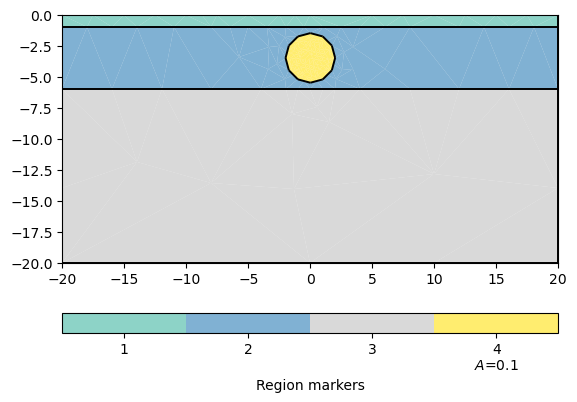

In [2]:
world = mt.createWorld(start=[-20, 0], end=[20, -20], layers=[-1, -6], worldMarker=1)
# Create some heterogeneous circle and merge with world
block = mt.createCircle(pos=[0, -3.5], radius=2, marker=4, boundaryMarker=10, area=0.1)
geom = mt.mergePLC([world, block])
pg.show(geom);

In [3]:
# place electrodes in the mesh and refine them
xEl = np.linspace(-10, 10, 21)
[geom.createNode((x, 0, 0), -99) for x in xEl]
[geom.createNode((x, -0.1, 0)) for x in xEl]
mesh = mt.createMesh(geom)
print(mesh)

Mesh: Nodes: 672 Cells: 1179 Boundaries: 1850


In [4]:
data = ert.createData(elecs=xEl, schemeName='dd')
data["k"] = ert.geometricFactors(data)
print(data)

Data: Electrodes: 21 data: 171


1

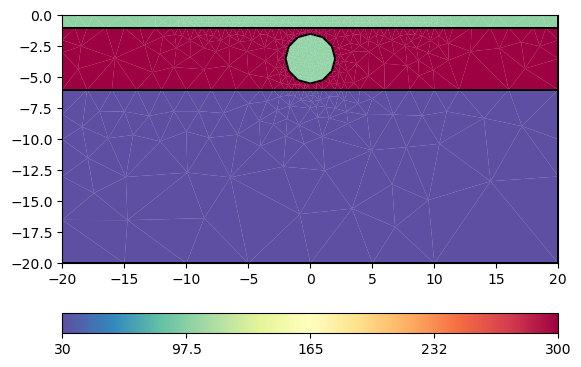

In [15]:
rhoMap = np.array([0, 100, 300, 30, 100], dtype=float)
rhoVec = rhoMap[mesh.cellMarkers()]
np.savetxt("rhovec.dat", rhoVec)
pg.show(mesh, rhoVec, cMap="Spectral_r");
mesh.save("mesh.bms")

18/12/22 - 06:22:42 - pyGIMLi - INFO - Found 1 regions.
18/12/22 - 06:22:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/12/22 - 06:22:42 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


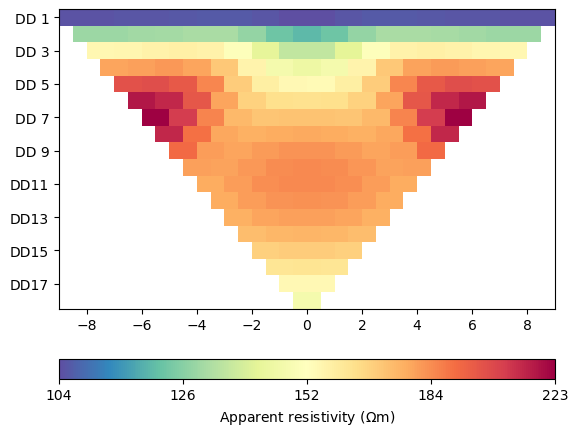

In [6]:
mesh0 = pg.Mesh(mesh)
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopDC = ert.ERTModelling()
fopDC.setMesh(mesh0)
fopDC.setData(data)
data["rhoa"] = fopDC.response(rhoVec)
pg.show(data, "rhoa");

In [7]:
fopDC.createJacobian(rhoVec)

In [8]:
fopIP = pb.tdip.DCIPMModelling(fopDC, mesh, rhoVec)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f698c433b80>)

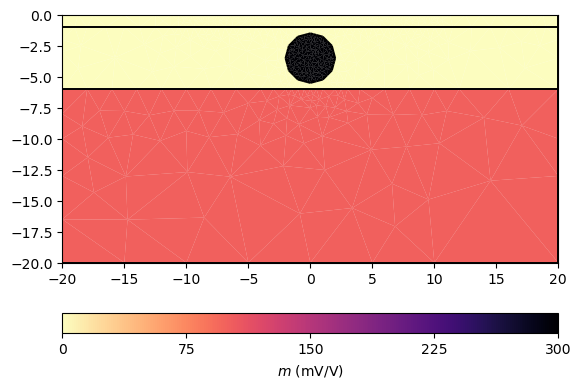

In [9]:
mMap = np.array([0, 0, 0, 0.1, 0.3])  # intrinsic chargeability
mVec = mMap[mesh.cellMarkers()]
pg.show(mesh, mVec*1000, logScale=False, label=r"$m$ (mV/V)", cMap="magma_r", cMin=0, cMax=300)

1

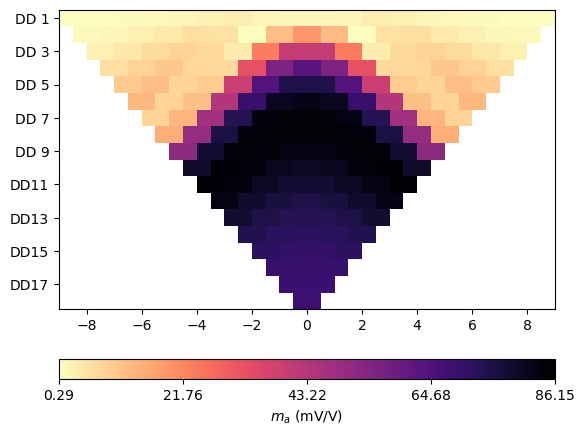

In [10]:
data["ma"] = fopIP.response(mVec)
pg.show(data, data["ma"]*1000, logScale=False, label=r"$m_a$ (mV/V)", cMap="magma_r");
data.save("simpleTDIP.dat", "a b m n rhoa k ma")

18/12/22 - 06:22:44 - pyGIMLi - INFO - Found 2 regions.
18/12/22 - 06:22:44 - pyGIMLi - INFO - Region with smallest marker (1) set to background
18/12/22 - 06:22:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/12/22 - 06:22:44 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.
18/12/22 - 06:22:44 - pyGIMLi - INFO - Use median(data values)=174.37618966372395
18/12/22 - 06:22:44 - pyGIMLi - INFO - Created startmodel from forward operator: 793 [174.37618966372395,...,174.37618966372395]


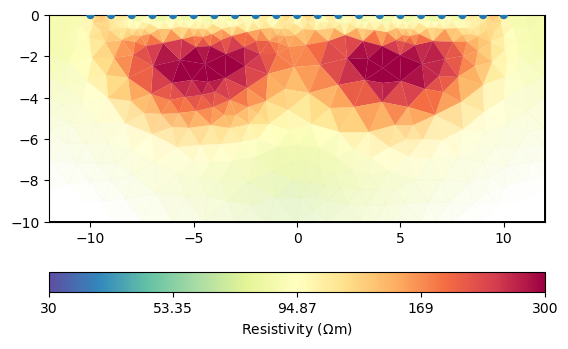

In [11]:
data["err"] = ert.estimateError(data, 0.03)
mgr = ert.Manager(data)
mgr.invert(paraDX=0.25, paraDepth=10, quality=34.4, paraMaxCellSize=1)
mgr.showResult(cMin=30, cMax=300);

18/12/22 - 06:22:46 - Core - INFO - More than 50 regions, so we assume single regions only.
18/12/22 - 06:22:46 - Core - INFO - Applying *:* interregion constraints.
18/12/22 - 06:22:46 - pyGIMLi - INFO - Starting inversion.


fop: <pybert.tdip.mipmodelling.DCIPMModelling object at 0x7f698c22a4f0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f698c6dcd60>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f698c44dae0>
min/max (data): 2.9e-04/0.09
min/max (error): 4.16%/342%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(dweight) = 278.986/991.239
min/max(dweight) = 278.986/991.239
Building constraints matrix
Creating inter region constraints.
constraint matrix of size(nBounds x nModel) 1137 x 793
calculating jacobian matrix (forced=1)...... 0 s
min data = 0.000294609 max data = 0.0861468 (171)
min error = 0.0416081 max error = 3.42433 (171)
min response = 0.1 max response = 0.1 (171)
calc without reference model
0: rms/rrms(data, response) = 0.0675756/6038.85%
0: chi^2(data, response, error, log) = 3096.25
0: Phi = 529458 + 0 * 10 = 529458
Iter: 0
solve CGLSCDWWtrans with lambda = 10
----------------------------

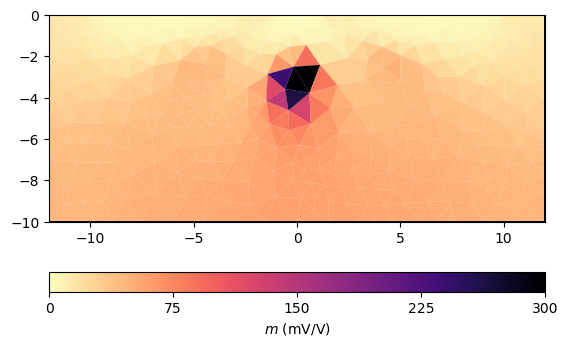

In [12]:
fopIP = pb.tdip.DCIPMModelling(mgr.fop, mgr.paraDomain, mgr.model, response=mgr.inv.response)
fopIP.createRefinedForwardMesh(True)
invIP = pg.Inversion(fop=fopIP, verbose=True)
errorIP = pg.Vector(data.size(), 0.03) + 0.001 / data["ma"]  # absolute ma 1mV/V plus 3%
modelIP = invIP.run(data["ma"], errorIP, startModel=0.1, lam=10, verbose=True)
pg.show(mgr.paraDomain, modelIP*1000, logScale=False, label=r"$m$ (mV/V)", cMap="magma_r", cMin=0, cMax=300);